# Calculate Spatiotemporal Power Spectrum of Movies

After Video Frames have been temporally synced on a common timeframe with the eye trackers, we can extract video frames knowing they are temporally synced to the eye tracker. 

## Dependencies

In [1]:
import os, stat
import numpy as np
import matplotlib.pyplot as plt
import imp

import utils.run_analysis as ana

import stftoolkit as stf
import datatable as dt

import imageio
import cv2

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/data_repo/bravo'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 80
vertical_fov_deg = 62

img_dims=(1544,2064)
save_batchsize = 200

chunk_secs = 5
chunk_pix = 256
chunk_frames = int(chunk_secs*fps)

num_chunks = 500

cosine_window = True

vertical_ppd = img_dims[0]/vertical_fov_deg
horizontal_ppd = img_dims[1]/horizontal_fov_deg
ppd = np.mean((vertical_ppd, horizontal_ppd))
print(f'Vertical PPD: {vertical_ppd:.2f}, Horizontal PPD {horizontal_ppd:.2f}, taking average {ppd:.2f}')

Vertical PPD: 24.90, Horizontal PPD 25.80, taking average 25.35


## Specify Directories for Exmaple

In [8]:
example_subject = 'jf'
example_trial = 'cell_phone_1'
example_camera = 'cy'
trial_directory = os.path.join(data_dir, example_subject, example_trial, 'pre')
camera_dir = os.path.join(trial_directory,'scene_camera')
save_dir = os.path.join('./output', example_subject, example_trial)

try:
    os.mkdir(save_dir)
except:
    print(f'{save_dir} already made!')

analysis_folder = os.path.join(output_dir, example_subject, example_trial,'')
common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')
pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'
trace_type='fixation_eye_1'

./output/jf/cell_phone_1 already made!


## Create Traces To Overlay

*** TODO: The no trace condition should be MATCHED to a true fixation point START. ***

In [9]:
timeline = np.load(common_timeline_file)
timeline_stamps = timeline[:,0]
timeline_ximea = timeline[:,1].astype(int)
timeline_pupil_eye0 = timeline[:,2].astype(int)
timeline_pupil_eye1 = timeline[:,3].astype(int)
timeline_task = timeline[:,4].astype(int)

#only use timelines during task
timeline_stamps = timeline_stamps[timeline_task==1]
timeline_ximea = timeline_ximea[timeline_task==1]
timeline_pupil_eye0 = timeline_pupil_eye0[timeline_task==1]
timeline_pupil_eye1 = timeline_pupil_eye1[timeline_task==1]

In [10]:
pupil_positions = dt.fread(pupil_positions_file)
pupil_positions = pupil_positions[:,[0,1,2,4,5]]
fixations_pupil_eye0 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==0)[0],:]
fixations_pupil_eye1 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==1)[0],:]

In [11]:
#generate a trace
def generate_trace(trace_type, chunk_frames, chunk_pix, img_dims, timeline_ximea, timeline_pupil_eye0, timeline_pupil_eye1, fixations_pupil_eye0, fixations_pupil_eye1):

    if(trace_type == 'none'):
        #locate in time
        trace_f_start = np.random.randint(0, len(timeline_ximea) - chunk_frames)
        trace_f = np.arange(trace_f_start, trace_f_start+chunk_frames)
        trace_ximea_fnum = timeline_ximea[trace_f]
        #locate in space
        trace_xy_corner = np.tile([np.random.randint(0,img_dims[1]-chunk_pix),
                                   np.random.randint(0,img_dims[0]-chunk_pix)],
                                  (chunk_frames,1)) #top left corner
 
    elif(trace_type == 'fixation_eye_0'):
        found_valid_fixation = False
        while(found_valid_fixation==False):
            print('*',end='')
            #locate in time
            trace_f_start = np.random.randint(0, len(timeline_ximea) - chunk_frames)
            trace_f = np.arange(trace_f_start, trace_f_start+chunk_frames)
            trace_ximea_fnum = timeline_ximea[trace_f]
            #locate in space
            trace_x_center = np.rint(fixations_pupil_eye0[timeline_pupil_eye0[trace_f_start:trace_f_start+chunk_frames],3]*img_dims[1]).astype(int)
            trace_y_center = np.rint(fixations_pupil_eye0[timeline_pupil_eye0[trace_f_start:trace_f_start+chunk_frames],4]*img_dims[0]).astype(int)
            trace_xy_corner = np.array(np.array((trace_x_center,trace_y_center)).T-(chunk_pix//2))
            #check to make sure we don't exit frame
            x_dims_ok = np.all(trace_xy_corner[:,0]>0) and np.all(trace_xy_corner[:,0]+chunk_pix<img_dims[1])
            y_dims_ok = np.all(trace_xy_corner[:,1]>0) and np.all(trace_xy_corner[:,1]+chunk_pix<img_dims[0])
            if(x_dims_ok and y_dims_ok):
                found_valid_fixation = True
                
    elif(trace_type == 'fixation_eye_1'):
        found_valid_fixation = False
        while(found_valid_fixation==False):
            print('*',end='')
            #locate in time
            trace_f_start = np.random.randint(0, len(timeline_ximea) - chunk_frames)
            trace_f = np.arange(trace_f_start, trace_f_start+chunk_frames)
            trace_ximea_fnum = timeline_ximea[trace_f]
            #locate in space
            trace_x_center = np.rint(fixations_pupil_eye1[timeline_pupil_eye1[trace_f_start:trace_f_start+chunk_frames],3]*img_dims[1]).astype(int)
            trace_y_center = np.rint(fixations_pupil_eye1[timeline_pupil_eye1[trace_f_start:trace_f_start+chunk_frames],4]*img_dims[0]).astype(int)
            trace_xy_corner = np.array(np.array((trace_x_center, trace_y_center)).T-(chunk_pix//2))
            #check to make sure we don't exit frame
            x_dims_ok = np.all(trace_xy_corner[:,0]>0) and np.all(trace_xy_corner[:,0]+chunk_pix<img_dims[1])
            y_dims_ok = np.all(trace_xy_corner[:,1]>0) and np.all(trace_xy_corner[:,1]+chunk_pix<img_dims[0])
            if(x_dims_ok and y_dims_ok):
                found_valid_fixation = True
                
    return(trace_f, trace_ximea_fnum, trace_xy_corner)

*

Text(0.5, 1.0, 'Example Trace')

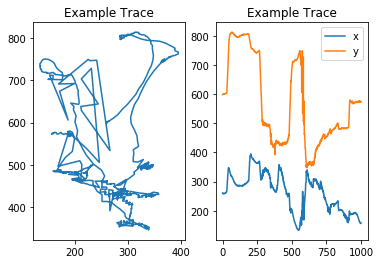

In [12]:
trace_f, trace_ximea_fnum, trace_xy_corner = generate_trace(trace_type, chunk_frames, chunk_pix, img_dims, timeline_ximea, timeline_pupil_eye0, timeline_pupil_eye1, fixations_pupil_eye0, fixations_pupil_eye1)
plt.subplot(1,2,1)
plt.plot(trace_xy_corner[:,0], trace_xy_corner[:,1])
plt.title('Example Trace')
plt.subplot(1,2,2)
plt.plot(trace_xy_corner[:,0],label='x')
plt.plot(trace_xy_corner[:,1],label='y')
plt.legend()
plt.title('Example Trace')

## Ensure Fixations are Located as Expected in Image

Use Converted Pupil Labs Data Structure. This gaze data has been aligned in world cam (Realsense) coordinates. To do this, after recording, drag the pupil labs folder ('000') into pupilplayer, then export. This wil create a few new files in the 000 folder, as well as an 'exports' folder with these converted files inside.   

The generated 'pupil_gaze_positions.txt' file contains a wealth of information explaining the generated files and how to interpret them.  

Specifically, for the 'norm_position_x' and y, we need to map the coordinate system to world camera coordinates.
"We use a normalized coordinate system with the origin 0,0 at the bottom left and 1,1 at the top right"

Look at Pupil player to make sure image is not flipped

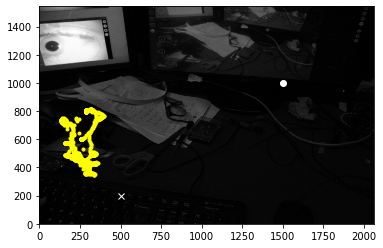

In [13]:
frame = np.fliplr(imageio.imread(os.path.join(analysis_folder,'pngs','cy',f'frame_{trace_ximea_fnum[0]}.png')))
plt.pcolormesh(np.mean(frame,axis=-1),cmap='Greys_r')
plt.plot(500,200,'x',c='white')
plt.plot(1500,1000,'o',c='white')
plt.plot(trace_xy_corner[:,0], trace_xy_corner[:,1],'.',c='yellow')

## Extract Movie at Trace x, y, f position

In [15]:
movie_chunk = np.zeros((len(trace_f), chunk_pix, chunk_pix, 3))
for i, f in enumerate(trace_ximea_fnum):
    print('*',end='')
    frame = imageio.imread(os.path.join(analysis_folder,'pngs','cy',f'frame_{f}.png'))
    movie_chunk[i] = frame[trace_xy_corner[i,1]:trace_xy_corner[i,1]+chunk_pix, 
                           trace_xy_corner[i,0]:trace_xy_corner[i,0]+chunk_pix]

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

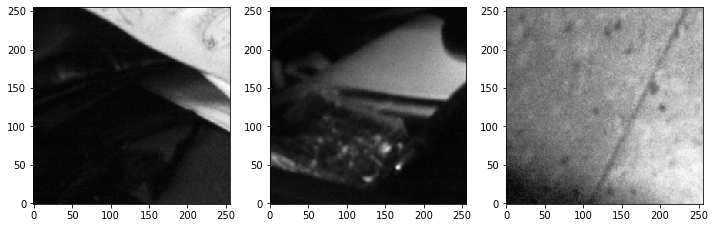

In [16]:
movie_chunk_norm = np.mean(movie_chunk,axis=-1)
movie_chunk_norm = movie_chunk_norm/np.max(movie_chunk_norm)
#movie_chunk_norm = movie_chunk
#movie_chunk_norm = movie_chunk/np.max(movie_chunk)
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(movie_chunk_norm[0],cmap='Greys_r', origin='lower')
plt.subplot(1,3,2)
plt.imshow(movie_chunk_norm[np.shape(movie_chunk_norm)[0]//2],cmap='Greys_r', origin='lower')
plt.subplot(1,3,3)
plt.imshow(movie_chunk_norm[-1],cmap='Greys_r', origin='lower')


## Write Movie to Disk

In [17]:
fourcc = cv2.VideoWriter_fourcc(*'mjpg')
if(len(np.shape(movie_chunk_norm))>3):
    video = cv2.VideoWriter(os.path.join(save_dir, f'example_chuunk_video_{trace_type}_color.avi'), fourcc, 100, (chunk_pix,chunk_pix))
    for i in range(np.shape(movie_chunk_norm)[0]):
        video.write(cv2.cvtColor(np.uint8(movie_chunk_norm[i]*255), cv2.COLOR_BGR2RGB))
    video.release()
else:
    video = cv2.VideoWriter(os.path.join(save_dir, f'example_chuunk_video_{trace_type}_bw.avi'), fourcc, 100, (chunk_pix,chunk_pix), 0)
    for i in range(np.shape(movie_chunk_norm)[0]):
        video.write(np.uint8(movie_chunk_norm[i]*255))
    video.release()


## Calculate the Spatiotemporal Fourier Transform of this Chunk

In [19]:
ps_3d, ps_2d, fqs_space, fqs_time = stf.st_ps(movie_chunk, ppd, fps, cosine_window=cosine_window, rm_dc=True)

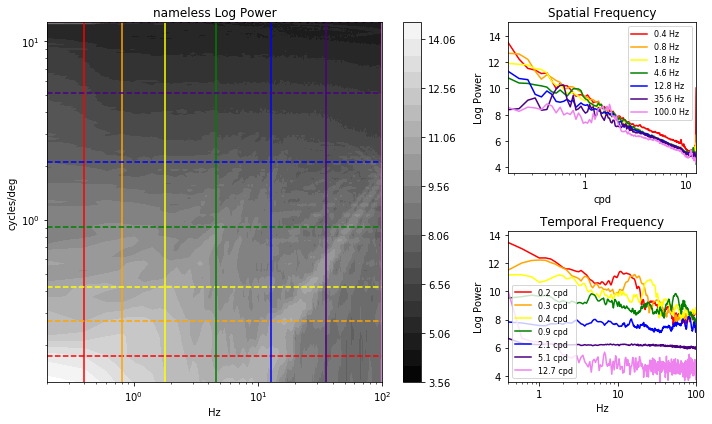

In [47]:
imp.reload(stf)
stf.da_plot_power(ps_2d, fqs_space, fqs_time, show_onef_line=False)

## Take the Average of Many Chunks and create FT plot

In [ ]:
ps_3d_mean = np.zeros_like(ps_3d)
ps_2d_mean = np.zeros_like(ps_2d)

print(f'Taking mean of {num_chunks} chunks...')
for i in range(num_chunks):
    trace_f, trace_ximea_fnum, trace_xy_corner = generate_trace(trace_type, chunk_frames, chunk_pix, img_dims, timeline_ximea, timeline_pupil_eye0, timeline_pupil_eye1, fixations_pupil_eye0, fixations_pupil_eye1)

    movie_chunk = np.zeros((len(trace_f), chunk_pix, chunk_pix, 3))

    for i, f in enumerate(trace_ximea_fnum):
        frame = imageio.imread(os.path.join(analysis_folder,'pngs','cy',f'frame_{f}.png'))
        movie_chunk[i] = frame[trace_xy_corner[i,1]:trace_xy_corner[i,1]+chunk_pix, 
                               trace_xy_corner[i,0]:trace_xy_corner[i,0]+chunk_pix]

    ps_3d, ps_2d, fqs_space, fqs_time = stf.st_ps(movie_chunk, ppd, fps, cosine_window=cosine_window, rm_dc=True)
    ps_3d_mean += ps_3d
    ps_2d_mean += ps_2d
    print('*',end='')

ps_3d_mean = ps_3d_mean/num_chunks
ps_2d_mean = ps_2d_mean/num_chunks

np.save(os.path.join(save_dir,f'ps_3d_mean_{num_chunks}_{trace_type}.npy'), ps_3d_mean)
np.save(os.path.join(save_dir,f'ps_2d_mean_{num_chunks}_{trace_type}.npy'), ps_2d_mean)
np.save(os.path.join(save_dir,f'ps_fqs_space_{num_chunks}_{trace_type}.npy'), fqs_space)
np.save(os.path.join(save_dir,f'ps_fqs_time_{num_chunks}_{trace_type}.npy'), fqs_time)

Taking mean of 500 chunks...
*******************************************************************************************************************************************

In [ ]:
stf.da_plot_power(ps_2d_mean, fqs_space, fqs_time, show_onef_line=False, 
                  figname=f'mean_Power_{num_chunks}_chunks_trace_{trace_type}', 
                  saveloc='./output')

## Test Separability

We need to determine how close this function is to a separable function. According to  Constantinou et al 2015, (https://arxiv.org/pdf/1509.07017.pdf) We can do this by determining how factorizable the covariance matrix is.

Another reference is Simpson et al (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4203479/)

A more common method is looking at the rank of the matrix using SVD

The interesting relationship in the power spectrum (1/f law) is in log space. So take the log before running SVD. This also puts the values of the matrix to max 30 or so, which is more numerically stable for SVD (values before log are 10^15)

In [ ]:
ps_2d_small = np.log(ps_2d_mean)
plt.hist(ps_2d_small.flatten(),bins=100)
#ps_2d_small = ps_2d_small/np.max(ps_2d_small) # no need to do this in log space
u,s,v = np.linalg.svd(ps_2d_small)

In [ ]:
plt.pcolormesh(u)
plt.colorbar()
plt.title('u')
plt.show()
plt.plot(u[0,:],label='first col')
plt.plot(u[:,0],label='first row')
plt.legend()
plt.title('U cols/rows')
plt.show()
print(f'Sigma Values: {[l for l in s[:5]]}')
plt.plot(s[:20])
plt.title('Sigma - first 30')
plt.show()
plt.pcolormesh(v)
plt.colorbar()
plt.title('V')
plt.show()

We seem to be in the realm of 'sort-of' separable. The first SV is large, and the second and beyond are much smaller. But they are definitely not zero either. Looking at the first column (spatial frequency), there is some noise.